# Setup

In [1]:
from huggingface_hub import login, whoami

login()

In [2]:
DATASET_PATH = f'{whoami()["name"]}/classification-ie-optimization'

In [3]:
import pandas as pd
df = pd.read_parquet(f"hf://datasets/{DATASET_PATH}/data/train-00000-of-00001.parquet")

image_dict = {
    'michaelf34/infinity:0.0.75-trt-onnx': 'trt-onnx',
    'michaelf34/infinity:0.0.75': 'default'
}

df['image'] = df['image'].map(image_dict)

df.columns

Index(['total_requests', 'test_duration_sec', 'successful_requests',
       'avg_latency_ms', 'p95_latency_ms', 'accuracy_percentage',
       'throughput_req_per_sec', 'hw_type', 'batch_size', 'image', 'engine',
       'vendor', 'vus', 'seconds_per_billion', 'cost_per_sec', '1B_cost'],
      dtype='object')

In [4]:
df.image.unique()

array(['trt-onnx', 'default'], dtype=object)

In [5]:
df[['1B_cost', 'hw_type', 'image', 'batch_size', 'vus', ]].sort_values(by='1B_cost').head()

1B_cost    hw_type     image  batch_size  vus
194  253.822554  nvidia-l4   default          64  448
106  255.065974  nvidia-l4  trt-onnx          64  448
107  255.948517  nvidia-l4  trt-onnx          64  480
108  256.502990  nvidia-l4  trt-onnx          64  464
105  258.885820  nvidia-l4  trt-onnx          64  384

# Sanity Checks

## Did we have any failed requests?

In [6]:
sum(df.total_requests - df.successful_requests)

0

## Did we try enough VUs?
How do we know that we tried enough VUs? What if we tried a higher amount of VUs and throughput kept increasing? If thats the case then we would see a monotonicly increasing relationship between VUs and Throughput and we would need to run more tests. Lets check this out!

We can check by:
1. **Grouping data** by `hw_type` and `batch_size` to match how we generated the experiments
1. **Sorting the data** by `vus` within each group to ensure we get the data in the correct order for our check
1. **Check for monotonic increase** in `throughput_req_per_sec` flag the groups that always increase throughput as VUs increase


Note: do a sanity check with the following code to make sure that this does indeed detect if it does in-fact detect the series you expect.
```python
df_filtered = df[df['vus'] <= 256]`
grouped = df_filtered.groupby(['hw_type', 'batch_size'])
```


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Grouping by 'hw_type' and 'batch_size'
grouped = df.groupby(['hw_type', 'batch_size'])

# Identifying monotonically increasing series for throughput_req_per_sec as vus increases
monotonic_series = {}
for (hw_type, batch_size), group in grouped:
    group_sorted = group.sort_values('vus')  # Ensure sorted order by vus
    if group_sorted['throughput_req_per_sec'].is_monotonic_increasing:
        monotonic_series[(hw_type, batch_size)] = group_sorted[['vus', 'throughput_req_per_sec']]

# Plotting the identified monotonically increasing series
for (hw_type, batch_size), data in monotonic_series.items():
    plt.figure(figsize=(8, 5))
    plt.plot(data['vus'], data['throughput_req_per_sec'], marker='o', linestyle='-')
    plt.xlabel('Virtual Users (VUs)')
    plt.ylabel('Throughput (Requests per Sec)')
    plt.title(f'Throughput Trend for HW: {hw_type}, Batch: {batch_size}')
    plt.grid(True)
    plt.show()

# Display the results in a DataFrame
monotonic_df = pd.DataFrame(
    [(hw, batch) for (hw, batch) in monotonic_series.keys()],
    columns=['hw_type', 'batch_size']
)

print(monotonic_df)


Empty DataFrame
Columns: [hw_type, batch_size]
Index: []


## Are we accurate enough?
We shouldn't expect to see significant changes in accuracy. We should see a pretty tight distribution, but there might be some deviation since for lower VUs we wont have as many samples of our `10_000` that we saw with higher VUs.

In [8]:
import plotly.figure_factory as ff
import plotly.graph_objects as go

mean_accuracy = df["accuracy_percentage"].mean()
std_dev_accuracy = df["accuracy_percentage"].std()

# Create a distribution plot (outline instead of bins)
fig = ff.create_distplot([df['accuracy_percentage']], ['Accuracy Percentage'], show_hist=False, show_rug=True)

# Add mean and standard deviation lines
fig.add_trace(go.Scatter(x=[mean_accuracy, mean_accuracy], y=[0, 1],
                         mode="lines", name="Mean", line=dict(color="red", dash="dash")))

fig.add_trace(go.Scatter(x=[mean_accuracy - std_dev_accuracy, mean_accuracy - std_dev_accuracy],
                         y=[0, 1],
                         mode="lines", name="Mean - 1 Std Dev", line=dict(color="blue", dash="dot")))

fig.add_trace(go.Scatter(x=[mean_accuracy + std_dev_accuracy, mean_accuracy + std_dev_accuracy],
                         y=[0, 1],
                         mode="lines", name="Mean + 1 Std Dev", line=dict(color="blue", dash="dot")))

# Update layout
fig.update_layout(title="Density Plot of Accuracy Percentage",
                  xaxis_title="Accuracy Percentage",
                  yaxis_title="Density",
                  showlegend=True)

# Show figure
fig.show()

In [9]:
# Display statistics
stats_df = pd.DataFrame({'Statistic': ['Mean', 'Standard Deviation'],
                         'Value': [mean_accuracy, std_dev_accuracy]})
stats_df

Statistic      Value
0                Mean  58.004479
1  Standard Deviation   0.267344

Here we can see some deviation with a large z-score, but overall its not that big of an absolute devation. These also occur when we have relatively low `total_requests` which makes sense. 

We should worry more if we see major `absolute_deviation` with higher `total_requests`. We can see those values here:

In [10]:
from scipy.stats import zscore

# Calculate absolute deviation from the mean
df['absolute_deviation'] = abs(df['accuracy_percentage'] - mean_accuracy)

# Calculate z-score
df['z_score'] = zscore(df['accuracy_percentage'])

# Get the top 5 outliers with the highest absolute deviation
top_outliers = df.nlargest(5, 'absolute_deviation')[['hw_type', 'batch_size', 'vus', 'total_requests', 'accuracy_percentage', 'absolute_deviation', 'z_score']]
top_outliers['accuracy_percentage'] = top_outliers['accuracy_percentage'].round(2)
top_outliers['absolute_deviation'] = top_outliers['absolute_deviation'].round(2)
top_outliers['z_score'] = top_outliers['z_score'].round(2)

top_outliers

hw_type  batch_size   vus  total_requests  accuracy_percentage  \
96   nvidia-l4          16   271             117                53.85   
93   nvidia-l4          16   384            4803                57.76   
102  nvidia-l4          64   128           10000                58.06   
115  nvidia-l4         128   256           10000                58.06   
127  nvidia-l4         256  1024           10000                58.06   

     absolute_deviation  z_score  
96                 4.16   -15.59  
93                 0.25    -0.93  
102                0.06     0.21  
115                0.06     0.21  
127                0.06     0.21

# Analysis

In [11]:
import plotly.express as px
import pandas as pd
import numpy as np

# Step 1: Identify rows where we have different images but the same VUs, HW Type, and batch_size
grouped = df.groupby(["vus", "batch_size", "hw_type"])

# Filter only those groups that have multiple unique images
valid_groups = grouped.filter(lambda x: x["image"].nunique() > 1)

# Step 2: Compute cost differences between images within the same (VUs, batch_size, hw_type)
def compute_best_image(group):
    """Find the best (cheapest) image in each (VUs, batch_size, hw_type) group."""
    group = group.sort_values("1B_cost", ascending=True)
    
    best_image = group.iloc[0]["image"] if not group.empty else None  # Safely get best image
    cost_max = group["1B_cost"].max()
    group["better_image"] = best_image
    group["cost_savings_percent"] = (
        100 * (cost_max - group["1B_cost"]) / cost_max if cost_max > 0 else 0
    )
    
    return group

cost_diffs = valid_groups.groupby(["vus", "batch_size", "hw_type"]).apply(compute_best_image).reset_index(drop=True)

# Step 3: Create a consistent color mapping for images
unique_images = cost_diffs["better_image"].unique()
colors = px.colors.qualitative.Set1  # Use a predefined color set

# Assign a color to each unique image
color_map = {image: colors[i % len(colors)] for i, image in enumerate(unique_images)}

# Step 4: Create a separate **scatter plot** for each HW type
for hw in cost_diffs["hw_type"].unique():
    subset = cost_diffs[cost_diffs["hw_type"] == hw]

    fig = px.scatter(
        subset,
        x="batch_size",
        y="vus",
        color="better_image",  # Color based on best image
        size="cost_savings_percent",  # Size based on % savings
        title=f"Best Image by Cost Savings - HW Type: {hw}<br><sup>Color = Best Image (Consistent). Size = Savings % of cheaper image</sup>",
        labels={"batch_size": "Batch Size (log)", "vus": "VUs (log)", "better_image": "Cheaper Image"},
        hover_data=["1B_cost", "cost_savings_percent"],
        log_x=True,  # Log scale for batch_size
        log_y=True,  # Log scale for VUs
        color_discrete_map=color_map,  # Keep the same color across charts
    )

    fig.show()


/tmp/ipykernel_95255/1112846481.py:25: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



So this is pretty interesting, we can see that for the most part it seems that `trt-onnx` is cheaper in both GPUs. The only major exception is `nvidia-t4` for a `batch_size=32`. 

## 1B Requests Cost vs. Latency

This scatter plot visualizes the relationship between **average latency (ms)** and **cost per billion requests per day** for different **hardware types (hw_type)** and **image processing configurations (image)**.

### How to Read the Chart:
- **Point Symbols**: Represent different **hardware + image** configurations.
- **Color Gradient**: Represents batch size, helping to see cost trends across different batch sizes.
- **Hover Data**: Displays additional details like **VUs, batch size, and throughput per second**.

### Key Features:
- **Global Minimum Cost (Red Star)**: Marks the configuration with the lowest cost.
- **Pareto Front (Red Dashed Line + Points)**: Highlights the most efficient configurations, minimizing both cost and latency. These configurations offer the best trade-offs.

### How to Use:
- Find the **lowest-cost, low-latency configurations** by looking at points near the bottom-left.
- Use the **Pareto front** to identify cost-effective configurations.
- Compare different **hardware and image processing strategies** to optimize your setup.

This visualization helps in selecting the best configuration balancing **performance (low latency)** and **cost efficiency**.


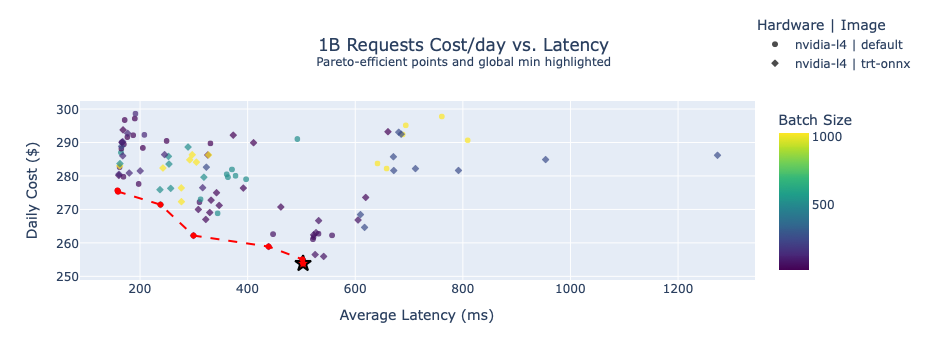

In [13]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Get the 500 lowest-cost points
bottom_100 = df.nsmallest(100, "1B_cost").copy()
bottom_100["1B_cost"] = bottom_100["1B_cost"].round(2)
bottom_100["throughput_req_per_sec"] = bottom_100["throughput_req_per_sec"].round(2)
bottom_100["avg_latency_ms"] = bottom_100["avg_latency_ms"].round(3)

# Create a combined column for unique symbol assignment
bottom_100["hw_image_combo"] = bottom_100["hw_type"] + " | " + bottom_100["image"]

# Find the global minimum cost point *only within* the bottom 100 points
global_min = bottom_100.nsmallest(1, "1B_cost")

# Function to find Pareto-efficient points (minimizing cost and latency)
def pareto_efficient(df, x_col, y_col):
    sorted_df = df.sort_values(by=[x_col, y_col])  # Sort by latency, then cost
    pareto_points = []
    min_cost = np.inf  # Start with a very high cost
    
    for _, row in sorted_df.iterrows():
        if row[y_col] < min_cost:  # If this cost is the lowest seen so far
            pareto_points.append(row)
            min_cost = row[y_col]
    
    return pd.DataFrame(pareto_points)

# Compute Pareto front
pareto_front = pareto_efficient(bottom_100, "avg_latency_ms", "1B_cost")

# Base scatter plot (showing 100 lowest-cost points)
fig = px.scatter(
    bottom_100, 
    x="avg_latency_ms", 
    y="1B_cost", 
    symbol="hw_image_combo",  # Use combined hw_type and image as symbol
    color="batch_size",  
    color_continuous_scale="viridis",  
    opacity=0.7, 
    title="1B Requests Cost/day vs. Latency<br><sup>Pareto-efficient points and global min highlighted</sup>",
    labels={
        "avg_latency_ms": "Average Latency (ms)",
        "1B_cost": "Daily Cost ($)",
        "hw_image_combo": "Hardware | Image",
        "batch_size": "Batch Size",
    },
    hover_data=["vus", "batch_size", "throughput_req_per_sec"]
)

# Add global minimum cost point (red star)
fig.add_trace(
    go.Scatter(
        x=global_min["avg_latency_ms"],
        y=global_min["1B_cost"],
        mode="markers",
        marker=dict(size=12, color="red", symbol="star", line=dict(width=2, color="black")),
        name="Global Min Cost",
        hovertemplate="Latency: %{x} ms<br>Cost: $%{y}<br>Batch Size: %{text}<br>VUs: %{customdata[0]}<br>Throughput: %{customdata[1]} req/sec",
        text=global_min["batch_size"],
        customdata=global_min[["vus", "throughput_req_per_sec"]].values,
        showlegend=False
    )
)

# Add Pareto curve with detailed hover info
fig.add_trace(
    go.Scatter(
        x=pareto_front["avg_latency_ms"],
        y=pareto_front["1B_cost"],
        mode="lines+markers",
        line=dict(color="red", width=2, dash="dash"),
        marker=dict(size=6, color="red"),
        name="Pareto Front",
        hovertemplate="Latency: %{x} ms<br>Cost: $%{y}<br>Batch Size: %{text}<br>VUs: %{customdata[0]}<br>Throughput: %{customdata[1]} req/sec",
        text=pareto_front["batch_size"],
        customdata=pareto_front[["vus", "throughput_req_per_sec"]].values,
        showlegend=False
    )
)

# Adjust layout (Center title)
fig.update_layout(
    title_x=0.5,  # Centers title
    legend=dict(
        x=1,  
        y=1.5,  
        title="Hardware | Image"
    )
)

fig.show()


## Cost vs VUs and Batch Size Contour Plots

These contour plots visualize the cost per billion tokens per day (`1B_cost`) as a function of **VUs (Virtual Users)** and **Batch Size** for different hardware configurations (`hw_type`) and image types (`image`). 

### How to Read the Charts:
- **Color Gradient**: Shows the cost levels, with darker colors representing higher costs and lighter colors representing lower costs.
- **Contour Lines**: Represent cost levels, helping identify cost-effective regions.
- **White Dots**: Represent real data points used to generate the interpolated surface.
- **Red Stars**: Highlight the lowest cost point in the dataset.
- **Small Red Dots**: Indicate the lowest cost for each batch size.

### How to Use:
- Identify the **lowest cost configurations** (red stars and dots).
- Observe how **cost changes** with batch size and VUs to optimize your setup.
- Compare different hardware types (`hw_type`) and image processing strategies (`image`) to find the best-performing configuration.

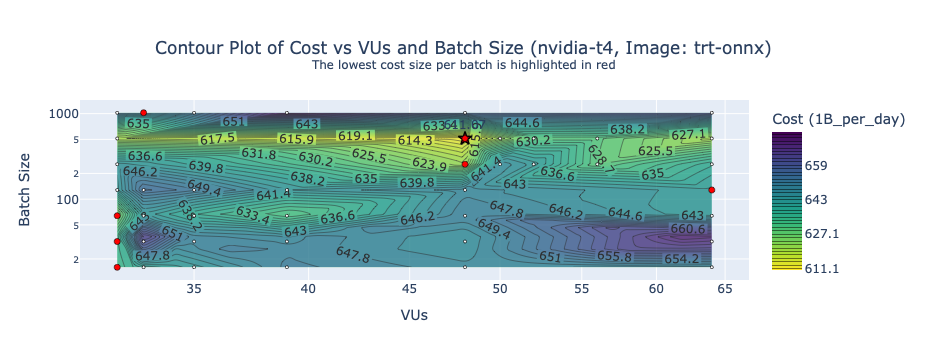

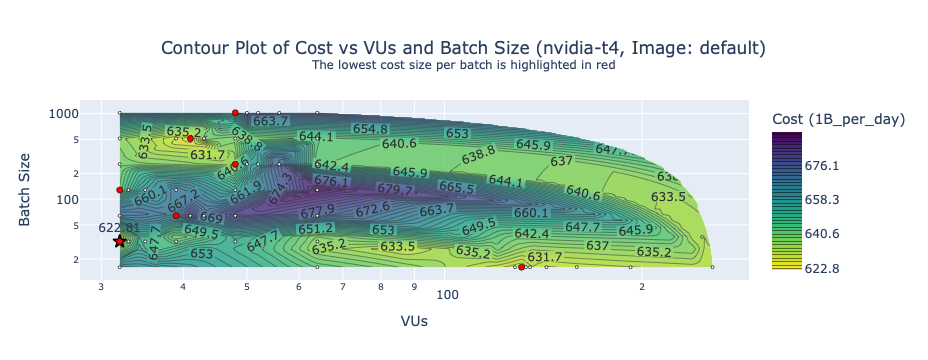

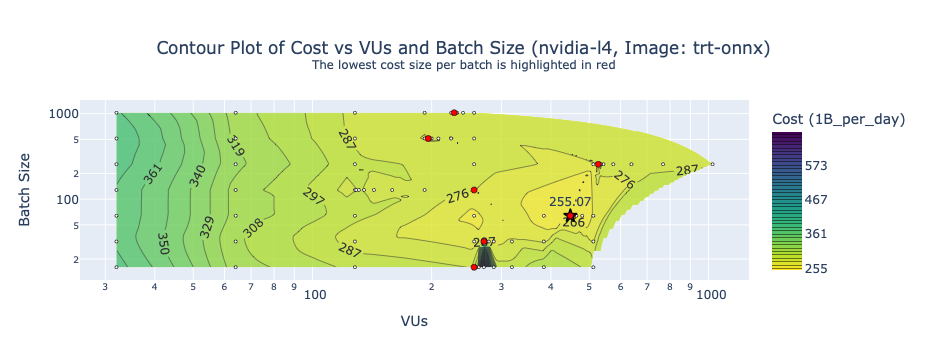

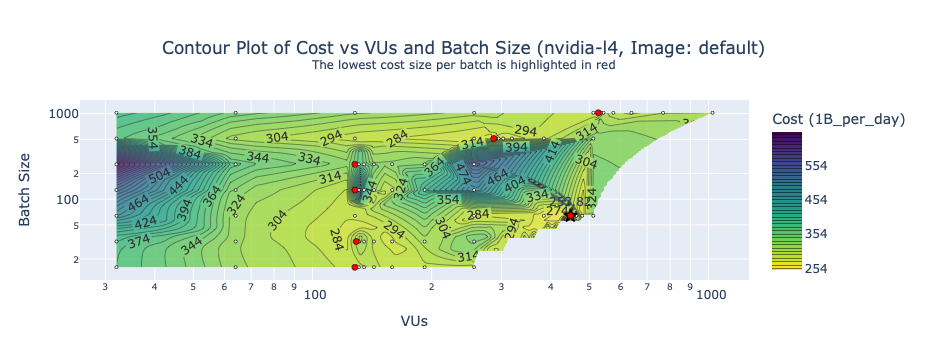

In [14]:
import plotly.graph_objects as go
import scipy.interpolate
import numpy as np
import pandas as pd

# Load your DataFrame (ensure it contains 'vus', 'batch_size', '1B_cost', 'hw_type', and 'image')
for hw in df["hw_type"].unique():
    for img in df["image"].unique():
        df_hw_img = df[(df["hw_type"] == hw) & (df["image"] == img) & (df["vus"] > 20)].copy()

        if df_hw_img.empty:
            continue  # Skip empty combinations

        # Define percentile bins for cost
        percentiles = np.linspace(0, 100, 40)  # Define bins using percentiles
        cost_bins = np.percentile(df_hw_img["1B_cost"], percentiles)  # Compute cost bins

        # Create grid for interpolation (Now X = VUs, Y = batch_size)
        grid_x_real, grid_y_real = np.meshgrid(
            np.linspace(df_hw_img["vus"].min(), df_hw_img["vus"].max(), 100),  # X-axis is now VUs
            np.linspace(df_hw_img["batch_size"].min(), df_hw_img["batch_size"].max(), 100)  # Y-axis is now batch_size
        )

        # Interpolate cost data (Now X = VUs, Y = batch_size)
        grid_z_real = scipy.interpolate.griddata(
            (df_hw_img["vus"], df_hw_img["batch_size"]),  # Order remains the same
            df_hw_img["1B_cost"],
            (grid_x_real, grid_y_real),  # Adjusted grid order
            method='linear'  # Linear interpolation for smoother transitions
        )

        # Identify the lowest cost point
        lowest_cost_points = df_hw_img.nsmallest(1, "1B_cost")

        # Identify the minimum cost point for each batch size
        min_per_batch = df_hw_img.loc[df_hw_img.groupby("batch_size")["1B_cost"].idxmin()]

        # Create Plotly figure
        fig_hw_img = go.Figure()

        # Contour plot with percentile-based cost bins
        fig_hw_img.add_trace(
            go.Contour(
                z=grid_z_real,
                x=np.linspace(df_hw_img["vus"].min(), df_hw_img["vus"].max(), 100),  # X-axis is now VUs
                y=np.linspace(df_hw_img["batch_size"].min(), df_hw_img["batch_size"].max(), 100),  # Y-axis is now batch_size
                colorscale="viridis_r",
                contours=dict(
                    start=cost_bins[0],
                    end=cost_bins[-1],
                    size=np.diff(cost_bins).mean(),  # Uses percentile bins
                    showlabels=True
                ),
                colorbar=dict(title="Cost (1B_per_day)"),
                hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{z}",
                opacity=0.8  # Reduce opacity to make scatter points stand out
            )
        )

        # Scatter plot of actual data points
        fig_hw_img.add_trace(
            go.Scatter(
                x=df_hw_img["vus"],  # X-axis is now VUs
                y=df_hw_img["batch_size"],  # Y-axis is now batch_size
                mode="markers",
                marker=dict(size=3, color="white", line=dict(width=0.5, color="black")),  
                name="Real Data Points",
                hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
                text=df_hw_img["1B_cost"].round(2),
                showlegend=False
            )
        )

        # Scatter plot for lowest global cost points (Red Stars)
        fig_hw_img.add_trace(
            go.Scatter(
                x=lowest_cost_points["vus"],
                y=lowest_cost_points["batch_size"],
                mode="markers+text",
                marker=dict(size=10, color="red", symbol="star", line=dict(width=1.5, color="black")),
                name="Lowest Cost Point",
                hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
                text=lowest_cost_points["1B_cost"].round(2),
                textposition="top center",
                showlegend=False
            )
        )

        # Scatter plot for minimum cost per batch size (Small Red Dots)
        fig_hw_img.add_trace(
            go.Scatter(
                x=min_per_batch["vus"],
                y=min_per_batch["batch_size"],
                mode="markers",
                marker=dict(size=6, color="red", line=dict(width=0.5, color="black")),
                name="Min Cost per Batch Size",
                hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
                text=min_per_batch["1B_cost"].round(2),
                showlegend=False
            )
        )

        fig_hw_img.update_layout(
            title=f"Cost vs VUs and Batch Size ({hw}, Image: {img})",
            xaxis_title="VUs",
            yaxis_title="Batch Size",
            xaxis_type="log",
            yaxis_type="log"
        )

        fig_hw_img.update_layout(
            title={
                "text": f"Contour Plot of Cost vs VUs and Batch Size ({hw}, Image: {img})<br><sup>The lowest cost size per batch is highlighted in red</sup>",
                "x": 0.5,  # Center align
                "y": 0.85,  # Adjust vertical position
            }
        )

        fig_hw_img.show()
